# First test using SKImage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift
from scipy.ndimage.interpolation import shift

import cv2
import numpy as np
from PIL import Image

import sys
sys.path.append('../..')
from core import *
from utils import *

t_elapsed = 0

In [2]:
def show_img(img1, img2):
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
    ax3 = plt.subplot(1, 3, 3)

    ax1.imshow(img1, cmap='gray')
    ax1.set_axis_off()
    ax1.set_title('Reference image')

    ax2.imshow(img2.real, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title('NIR image')

    # Show the output of a cross-correlation to show what the algorithm is
    # doing behind the scenes
    image_product = np.fft.fft2(img1) * np.fft.fft2(img2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ax3.imshow(cc_image.real)
    ax3.set_axis_off()
    ax3.set_title("Cross-correlation")

    plt.show()

### open images and color map lookup table

In [3]:
cmap = np.genfromtxt('../../cmap.csv', delimiter=',')
#kernel = np.ones((5,5),np.float32)/25
img = cv2.imread('../Images/RGB.png')
img = cv2.medianBlur(img,5)#GaussianBlur(img,(5,5),0)
#print(img.shape)
[b, g, r] = channelSplit(img)
r = np.asarray(r.T[0]).astype(float).T
b = np.asarray(b.T[0]).astype(float).T
g = np.asarray(g.T[0]).astype(float).T

img2 = cv2.imread('../Images/NGB.png')
img2 = cv2.medianBlur(img2,5)#GaussianBlur(img2,(5,5),0)
#print(img.shape)
[b2, g2, r2] = channelSplit(img2)
r2 = np.asarray(r2.T[0]).astype(float).T
b2= np.asarray(b2.T[0]).astype(float).T
g2 = np.asarray(g2.T[0]).astype(float).T

### find offset between images

In [12]:
Rimg = r #red pixel set from pi camera
NIRoff = r2 #NIR pixel set from NOIR camera

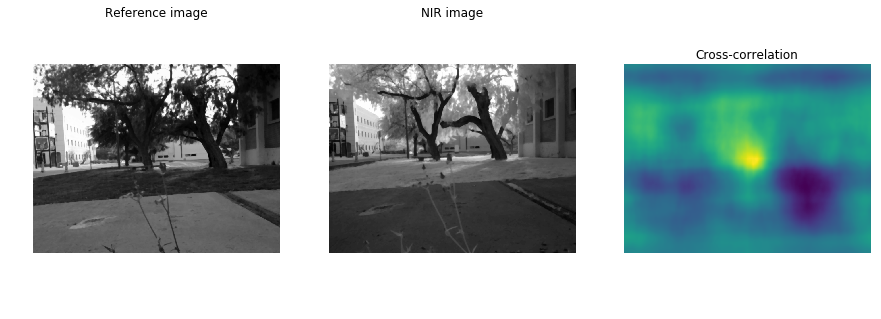

time = 0.17388153076171875
Detected pixel offset (y, x): [  0.  30.]


In [13]:
show_img(Rimg, NIRoff)
t_new = time()
shiftXY, error, diffphase = register_translation(Rimg, NIRoff) 
t_elapsed += time() - t_new
print("time = "+ str(t_elapsed))
print("Detected pixel offset (y, x): {}".format(shiftXY))


### Shift NIR image

#### Iteration 1

In [14]:
t_new = time()
NIRimg = shift(NIRoff, np.array(shiftXY))
t_elapsed += time() - t_new
print("time = "+ str(t_elapsed))

time = 0.2328472137451172


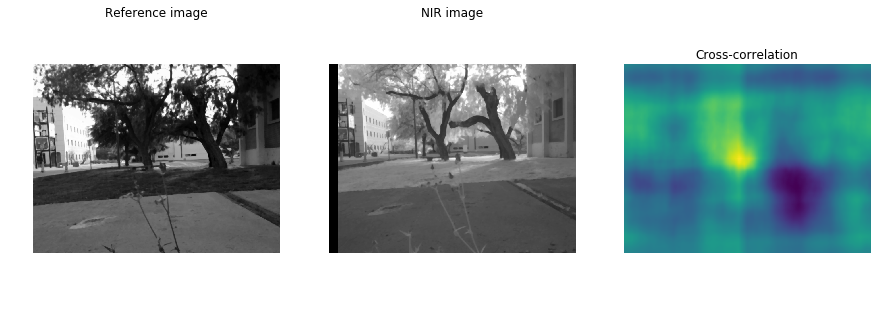

Detected pixel offset (y, x): [  0. -30.]


In [15]:
show_img(Rimg, NIRimg)
shiftXY, error, diffphase = register_translation(Rimg, NIRimg)
print("Detected pixel offset (y, x): {}".format(shiftXY))

#### check NDVI

# Additional test with same images using imreg_dft

In [16]:
import imreg_dft
t_elapsed = 0

E:\ProgramFiles\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


time = 0


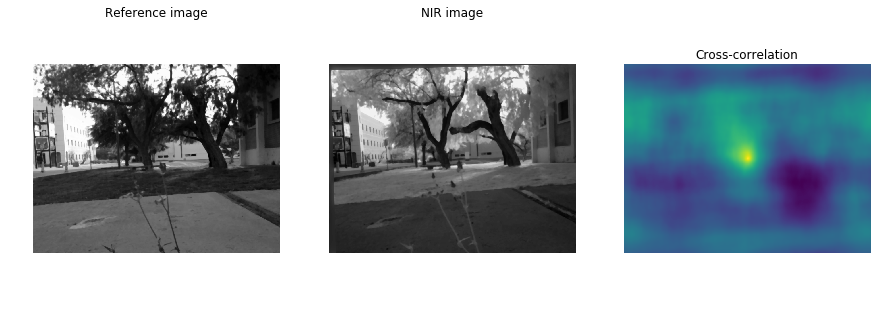

In [17]:
#t_new = time()
trans = imreg_dft.imreg.similarity(Rimg, NIRoff)
#t_elapsed += time() - t_new
print("time = "+ str(t_elapsed))
show_img(Rimg,trans['timg'])

#### check NDVI

In [18]:
init('../../cmap.csv')
ndvi_img = ndvi_map(Rimg, trans['timg'])
NDVI_imregdft = Image.fromarray(ndvi_img)

ndvi_img = ndvi_map(Rimg, NIRimg)
NDVI_skimage = Image.fromarray(ndvi_img)

In [19]:
NDVI_skimage.save('../Images/NDVI_skimage.jpg')
NDVI_imregdft.save('../Images/NDVI_imregdft.jpg')